# Importing the libraries


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import numpy as np
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Average 


# Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
training_set = train_datagen.flow_from_directory("C:/DT/train",
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 613 images belonging to 4 classes.


In [20]:
test_set = test_datagen.flow_from_directory("C:/DT/test",
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 315 images belonging to 4 classes.


In [21]:
valid_set = test_datagen.flow_from_directory("C:/DT/valid",
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)




Found 72 images belonging to 4 classes.


In [22]:
# Extract labels from the test set for evaluation
test_labels = test_set.classes

valid_labels = valid_set.classes

train_labels = training_set.classes

# Inception model

In [23]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in inception_v3.layers[: -15]:
    layer.trainable = False
    
x = inception_v3.output
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(units=4, activation='softmax')(x)
model = Model(inception_v3.input, output)

model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [24]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



In [58]:

checkpoint = ModelCheckpoint(
    filepath='Chest_CT_SCAN_Inception.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=20,
    callbacks=[checkpoint, earlystop],
    verbose=1    
)


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.9103
Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to Chest_CT_SCAN_Inception.h5
20/20 [==============================] - 25s 1s/step - loss: 0.2667 - accuracy: 0.9103 - val_loss: 0.7162 - val_accuracy: 0.8889
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.9184
Epoch 2: val_accuracy did not improve from 0.88889
20/20 [==============================] - 23s 1s/step - loss: 0.2982 - accuracy: 0.9184 - val_loss: 0.7725 - val_accuracy: 0.7361
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8989
Epoch 3: val_accuracy did not improve from 0.88889
20/20 [==============================] - 22s 1s/step - loss: 0.3030 - accuracy: 0.8989 - val_loss: 0.4678 - val_accuracy: 0.8611
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9233
Epoch 4: val_accuracy did not improve f

# Evaluation 

In [42]:
model.evaluate(test_set)

10/10 [==============================] - 8s 704ms/step - loss: 0.6465 - accuracy: 0.8222


[0.6464875936508179, 0.8222222328186035]

# visualizion

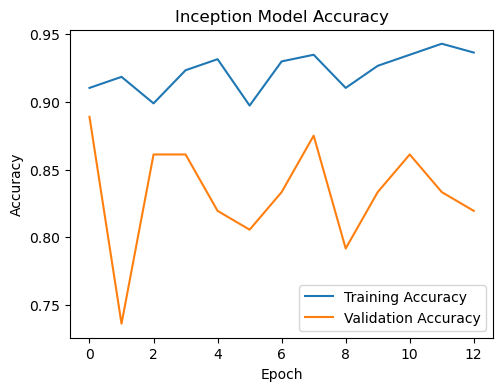

In [67]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Inception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

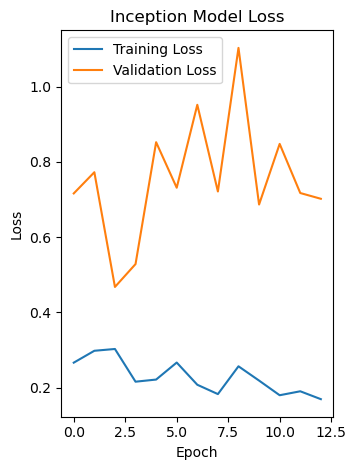

In [68]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Inception Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Resnet Model

In [26]:
base_model = tf.keras.applications.ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(224, 224, 3))
for layer in base_model.layers[: -15]:
    layer.trainable = False
model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4,activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_94 (Ba  (None, 100352)            401408    
 tchNormalization)                                               
                                                                 
 dense_3 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 1028      
                                                        

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model1.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])



In [29]:
checkpoint = ModelCheckpoint(
    filepath='Chest_CT_SCAN_resnet.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)
history1 = model1.fit(
    training_set,
    validation_data=valid_set,
    epochs=20,
    callbacks=[checkpoint, earlystop],
    verbose=1
)


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 1.1778 - accuracy: 0.5073
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to Chest_CT_SCAN_resnet.h5
20/20 [==============================] - 48s 2s/step - loss: 1.1778 - accuracy: 0.5073 - val_loss: 1.4026 - val_accuracy: 0.4583
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.5693
Epoch 2: val_accuracy improved from 0.45833 to 0.48611, saving model to Chest_CT_SCAN_resnet.h5
20/20 [==============================] - 46s 2s/step - loss: 1.0639 - accuracy: 0.5693 - val_loss: 1.3058 - val_accuracy: 0.4861
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.6362
Epoch 3: val_accuracy did not improve from 0.48611
20/20 [==============================] - 39s 2s/step - loss: 0.8992 - accuracy: 0.6362 - val_loss: 1.2835 - val_accuracy: 0.3750
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.7744 - accuracy: 0.68

# Evaluation

In [41]:
model1.evaluate(test_set)

10/10 [==============================] - 14s 1s/step - loss: 0.8543 - accuracy: 0.6286


[0.8542985916137695, 0.6285714507102966]

# Visualization

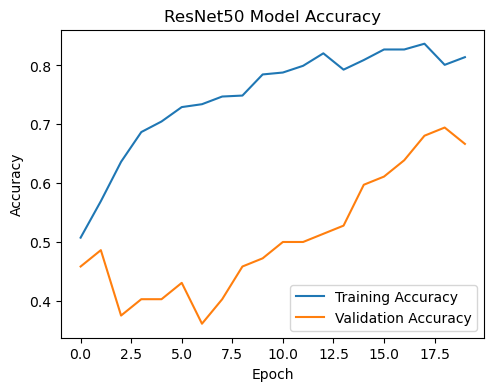

In [54]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

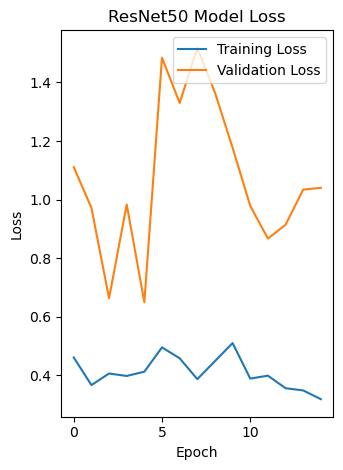

In [55]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Enasmple model

In [59]:

# Load the models
model_1 = load_model('Chest_CT_SCAN_Inception.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='Inception_Model')  

model_2 = load_model('Chest_CT_SCAN_ResNet50.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='ResNet_Model')  

# Create ensemble model
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='Ensemble_Model')  


In [60]:
loss1 = tf.keras.losses.CategoricalCrossentropy()
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
ensemble_model.compile(optimizer=optimizer1, 
                       loss=loss1, 
                       metrics=['accuracy'])

In [61]:
ensemble_model.summary()

Model: "Ensemble_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Inception_Model (Functiona  (None, 4)                    4828240   ['input_4[0][0]']             
 l)                                                       4                                       
                                                                                                  
 ResNet_Model (Functional)   (None, 4)                    4968051   ['input_4[0][0]']             
                                                          6                                       
                                                                                     

In [62]:
checkpoint_acc = ModelCheckpoint(
    filepath='Chest_CT_SCAN_Ensample_acc.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

checkpoint_val_acc = ModelCheckpoint(
    filepath='Chest_CT_SCAN_Ensample_val_acc.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)


history2 = ensemble_model.fit(
    training_set,
    validation_data=valid_set,
    callbacks=[checkpoint_acc, checkpoint_val_acc, earlystop],
    verbose=1,
    epochs=20
)


Found 72 images belonging to 4 classes.
Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7145
Epoch 1: accuracy improved from -inf to 0.71452, saving model to Chest_CT_SCAN_Ensample_acc.h5

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to Chest_CT_SCAN_Ensample_val_acc.h5
20/20 [==============================] - 80s 3s/step - loss: 0.6562 - accuracy: 0.7145 - val_loss: 1.1736 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.5648 - accuracy: 0.6542
Epoch 2: accuracy did not improve from 0.71452

Epoch 2: val_accuracy improved from 0.50000 to 0.54167, saving model to Chest_CT_SCAN_Ensample_val_acc.h5
20/20 [==============================] - 60s 3s/step - loss: 0.5648 - accuracy: 0.6542 - val_loss: 2.1134 - val_accuracy: 0.5417
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.7129
Epoch 3: accuracy did not improve from 0.71452

Epoch 3: val_accura

# Evaluation

In [64]:
ensemble_model.evaluate(test_set)

10/10 [==============================] - 19s 2s/step - loss: 0.9732 - accuracy: 0.5746


[0.9732230305671692, 0.5746031999588013]

# Visualization

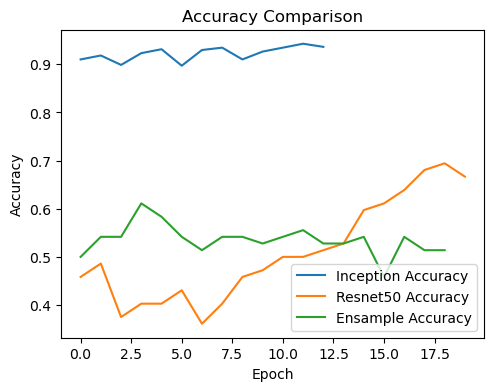

In [65]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Inception Accuracy')
plt.plot(history1.history['val_accuracy'], label='Resnet50 Accuracy')
plt.plot(history2.history['val_accuracy'], label='Ensample Accuracy')

plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

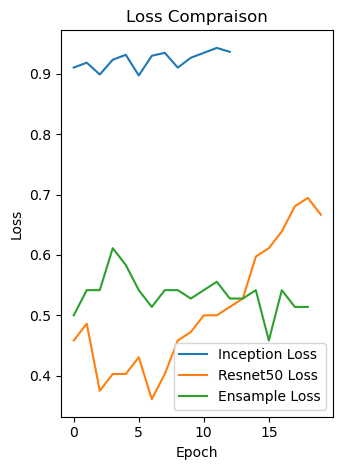

In [66]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Inception Loss')
plt.plot(history1.history['val_accuracy'], label='Resnet50 Loss')
plt.plot(history2.history['val_accuracy'], label='Ensample Loss')
plt.title('Loss Compraison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()